# First application with datacubes - NDVI Calculation

We want to calculate the NDVI values for a spatial extend from the start of september to te end of october.

In [1]:
import openeo
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import numpy as np
import rasterio


Establish an authenticated connection to Copernicus Data Space Ecosystem openEO back-end.

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

### Creating a Datacube

Now that we are connected, we can initialize our first SENTINEL2_L2A datacube object on the est of Toulouse between september and october 2023.

In [3]:
s2_timeseries = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2023-05-01", "2023-06-24"),
    spatial_extent={
        "west":  2.213649,
        "south": 43.450702,
        "east": 2.251248,
        "north":  43.472631,
        "crs": "EPSG:4326",
    },
    bands=["B02", "B03", "B04", "B08", "SCL"],
    max_cloud_cover=50,
);

s2_timeseries

Additonal information :
- temporal_extent can be expressed in "yyyy-mm-dd" or datetime.date objects; the start date is included, end date is excluded
- spatial_extent is by default in the standard Coordinate Reference System for the world (WGS 84)
  
All these data selection can also be done line by line:

In [4]:
# Select collection product to get a datacube object
s2_timeseries_bis = connection.load_collection("SENTINEL2_L2A")

# For any ds2_timeseries_bisatacube, we can filter by several parameters: 
s2_timeseries_bis = s2_timeseries_bis.filter_bbox(west=2.213649, east=2.251248, north=43.472631,south=43.450702, crs="EPSG:4326") 
s2_timeseries_bis = s2_timeseries_bis.filter_temporal("2023-05-01", "2023-06-24")
s2_timeseries_bis = s2_timeseries_bis.filter_bands(["B02", "B03", "B04", "B08", "SCL"])
# s2_timeseries = s2_timeseries.filter_labels(condition = {max_cloud_cover=50}) TODO

s2_timeseries

#### Export and visualize data 

To verify the data, we can export the results into various popular formats: GeoTiff, NetCDF, CSV, JSON, …

In [57]:
s2_timeseries.download("output/s2_timeseries.nc")

In [58]:
ds = xarray.load_dataset("output/s2_timeseries.nc")
ds

<xarray.Dataset> Size: 9MB
Dimensions:  (t: 6, x: 308, y: 248)
Coordinates:
  * t        (t) datetime64[ns] 48B 2023-05-02 2023-05-17 ... 2023-06-16
  * x        (x) float64 2kB 4.364e+05 4.364e+05 ... 4.394e+05 4.394e+05
  * y        (y) float64 2kB 4.814e+06 4.814e+06 ... 4.811e+06 4.811e+06
Data variables:
    crs      |S1 1B b''
    B02      (t, y, x) float32 2MB 929.0 722.0 368.0 183.0 ... 278.0 273.0 277.0
    B03      (t, y, x) float32 2MB 1.244e+03 925.0 549.0 ... 518.0 508.0 484.0
    B04      (t, y, x) float32 2MB 1.38e+03 1.018e+03 484.0 ... 230.0 236.0
    B08      (t, y, x) float32 2MB 2.454e+03 2.366e+03 ... 4.664e+03 4.792e+03
    SCL      (t, y, x) float32 2MB 5.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

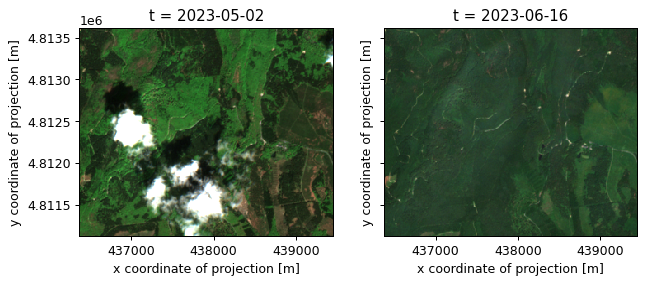

In [16]:
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);


### Use a process already implemented

In [6]:
native_ndvi_timeseries = s2_timeseries.process(
    process_id="ndvi", 
    arguments={
        "data": s2_timeseries, 
        "nir": "B04", 
        "red": "B08"}
)

# NDVI 
native_ndvi_timeseries.download("output/ndvi_r.nc")
ds = xarray.load_dataset("output/ndvi_r.nc")
ds

<xarray.Dataset> Size: 2MB
Dimensions:  (t: 6, x: 308, y: 248)
Coordinates:
  * t        (t) datetime64[ns] 48B 2023-05-02 2023-05-17 ... 2023-06-16
  * x        (x) float64 2kB 4.364e+05 4.364e+05 ... 4.394e+05 4.394e+05
  * y        (y) float64 2kB 4.814e+06 4.814e+06 ... 4.811e+06 4.811e+06
Data variables:
    crs      |S1 1B b''
    var      (t, y, x) float32 2MB -0.2801 -0.3983 -0.654 ... -0.906 -0.9061
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

### Use personnal process

In [18]:
band_red = s2_timeseries.band("B04")
band_nir = s2_timeseries.band("B08")
ndvi_timeseries = (band_nir - band_red) / (band_nir + band_red)

# Build mask to mask out everything but class 4 (vegetation)
scl_band = s2_timeseries.band("SCL")
mask_timeseries = (scl_band != 4)

# Apply the mask to the NDVI
ndvi_timeseries_masqued = ndvi_timeseries.mask(mask_timeseries)

### Use UDF process

In [17]:
# NDVI calculation can be done by UDF, User-Defined Functions, for each date (t)
# Reminder: datacube = [t, band, x, y] 

udf_ndvi = openeo.UDF("""
from openeo.udf import XarrayDataCube


def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    arr = cube.get_array()

    B4 = arr.loc[:, "B04"]
    B8 = arr.loc[:, "B08"]
    ndvi = (B8 - B4)/(B8 + B4)

    # extend bands dim
    ndvi = ndvi.expand_dims(dim="bands", axis=-3)

    # wrap back to datacube and return
    return XarrayDataCube(ndvi)

""")

# NDVI 
s2_timeseries_ndvi_udf = s2_timeseries.filter_bands(["B04", "B08"]).apply_dimension(process=udf_ndvi, dimension='t')

### Export data

#### Export data into GeoTIFF
To export an image, we need to specify how OpenEO needs to combine the data to create a composite before geting exported. As there is several date in the datacube, this can be done by applying one of the available functions such as `max_time`, to select only the last date.

In [20]:
native_ndvi_timeseries.max_time().download("output/ndvi_date.tiff")
# or native_ndvi_timeseries.max_time().save_result(format="GTiff")

In [21]:
with rasterio.open("output/ndvi_date.tiff") as ds:
    data = ds.read(1)

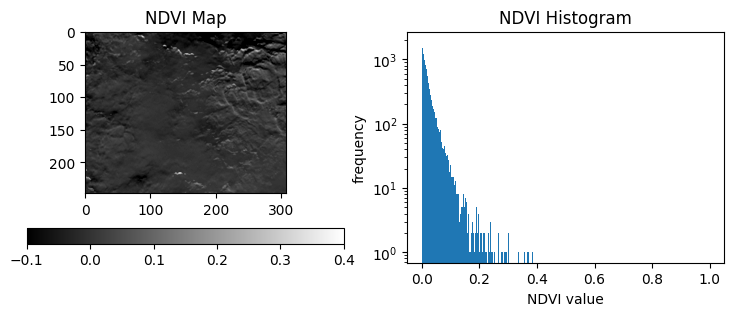

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 3))
im = ax1.imshow(data, cmap='gray',vmin=-0.1,vmax=0.4)
plt.colorbar(im, ax=ax1, orientation="horizontal")
ax1.set_title("NDVI Map")
ax2.hist(data.flat, bins=1000,range=[0.0,1.0], log=True)  
ax2.set_title("NDVI Histogram")
ax2.set_xlabel("NDVI value")
ax2.set_ylabel("frequency");